In [ ]:
%env LLM_API_KEY=替换为自己的key
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1

In [2]:
%%capture --no-stderr
!pip install -U langchain langchain_community langchain_openai pypdf sentence_transformers chromadb shutil openpyxl FlagEmbedding

In [3]:
import langchain, langchain_community, pypdf, sentence_transformers, chromadb, langchain_core

for module in (langchain, langchain_core, langchain_community, pypdf, sentence_transformers, chromadb):
    print(f"{module.__name__:<30}{module.__version__}")

/opt/anaconda3/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


langchain                     0.2.10
langchain_core                0.2.28
langchain_community           0.2.9
pypdf                         4.3.1
sentence_transformers         3.0.1
chromadb                      0.5.4


In [4]:
import os
import pandas as pd

In [5]:
expr_version = 'retrieval_v7_hyde'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

# 读取文档

In [6]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))
documents = loader.load()

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

# 文档切分

In [7]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [8]:
splitted_docs = split_docs(documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


# 检索

In [9]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings

device: cuda


In [10]:
import shutil
from langchain_community.vectorstores import Chroma

# 可以替换为本机路径
model_path = 'BAAI/bge-large-zh-v1.5'

def get_vector_db(embeddings, docs, db_name):
    persist_directory = os.path.join(expr_dir, 'chroma', db_name)
    shutil.rmtree(persist_directory, ignore_errors=True)

    vector_db = Chroma.from_documents(
        splitted_docs,
        embedding=embeddings,
        persist_directory=persist_directory
    )
    return vector_db

In [11]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

## 不使用HyDE

In [12]:
embeddings = get_embeddings(model_path)
vector_db = get_vector_db(embeddings, splitted_docs, 'vanilla_retrieval')

In [13]:
from tqdm.auto import tqdm

def get_hit_stat_df(vector_db, top_k_arr=list(range(1, 9))):
    hit_stat_data = []
    pbar = tqdm(total=len(top_k_arr) * len(test_df))
    for k in top_k_arr:
        pbar.set_description(f'k={k}')
        # retriever = vector_db.as_retriever(search_kwargs={'k': k})
        for idx, row in test_df.iterrows():
            question = row['question']
            true_uuid = row['uuid']
            chunks = vector_db.similarity_search(question, k=k)
            retrieved_uuids = [doc.metadata['uuid'] for doc in chunks]

            hit_stat_data.append({
                'question': question,
                'top_k': k,
                'hit': int(true_uuid in retrieved_uuids),
                'retrieved_chunks': len(chunks)
            })
            pbar.update(1)
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

In [14]:
orig_query_hit_stat_df = get_hit_stat_df(vector_db)
orig_query_hit_stat_df['HyDE'] = 'w/o'

  0%|          | 0/744 [00:00<?, ?it/s]

## 使用HyDE

In [15]:
from langchain_community.chat_models import ChatOllama
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import HypotheticalDocumentEmbedder
import re

llm = ChatOllama(base_url='http://localhost:11434', model='qwen2:7b-instruct')

prompt = PromptTemplate(
    input_variables=['question'],
    template = """你是一位精通财经的专业分析师，请基于用户提问，回答问题。
问题：{question}
请回答：
"""
)

hyde_embedding = HypotheticalDocumentEmbedder.from_llm(llm, base_embeddings=embeddings, custom_prompt=prompt)
hyde_vector_db = get_vector_db(hyde_embedding, splitted_docs, 'hyde')

In [16]:
llm.invoke('你是谁')

AIMessage(content='我是阿里云开发的一款超大规模语言模型，我叫通义千问。作为一个AI助手，我的目标是帮助用户获得准确、有用的信息，解决他们的问题和困惑。我可以回答各种领域的问题，提供代码实现、解释概念、提供建议等。请随时告诉我您需要帮助的内容，我会尽力提供支持。', response_metadata={'model': 'qwen2:7b-instruct', 'created_at': '2024-10-01T14:02:31.26354926Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 2895563597, 'load_duration': 1588807712, 'prompt_eval_count': 10, 'prompt_eval_duration': 42270000, 'eval_count': 71, 'eval_duration': 1219858000}, id='run-9ab48c32-3bd3-46b0-8887-98c3108a192e-0')

In [17]:
def get_hyde_hit_stat_df(vector_db, k):
    hit_stat_data = []
    pbar = tqdm(total=1 * len(test_df))
    pbar.set_description(f'k={k}')

    for idx, row in test_df.iterrows():
        question = row['question']
        true_uuid = row['uuid']

        chunks = vector_db.similarity_search(question, k=k)
        retrieved_uuids = [doc.metadata['uuid'] for doc in chunks]

        hit_stat_data.append({
            'question': question,
            'top_k': k,
            'hit': int(true_uuid in retrieved_uuids),
            'retrieved_chunks': len(chunks)
        })
        pbar.update(1)
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

In [18]:
from concurrent.futures import ThreadPoolExecutor

top_k_arr=list(range(1, 9))

hyde_hit_stat_data = []
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = {k: executor.submit(get_hyde_hit_stat_df, hyde_vector_db, k) for k in top_k_arr}
    for k in futures:
        hyde_hit_stat_data.append(futures[k].result())
hyde_hit_stat_df = pd.concat(hyde_hit_stat_data)
hyde_hit_stat_df['HyDE'] = 'w/'

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/anaconda3/lib/python3.10/site-packages/tqdm/_monitor.py", line 69, in run
    instances = self.get_instances()
  File "/opt/anaconda3/lib/python3.10/site-packages/tqdm/_monitor.py", line 49, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
  File "/opt/anaconda3/lib/python3.10/_weakrefset.py", line 97, in copy
    return self.__class__(self)
  File "/opt/anaconda3/lib/python3.10/_weakrefset.py", line 51, in __init__
    self.update(data)
  File "/opt/anaconda3/lib/python3.10/_weakrefset.py", line 124, in update
    for element in other:
  File "/opt/anaconda3/lib/python3.10/_weakrefset.py", line 65, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

In [19]:
hit_stat_df = pd.concat([orig_query_hit_stat_df, hyde_hit_stat_df])

In [20]:
hit_stat_df.groupby(['HyDE', 'top_k'])['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,HyDE,top_k,hit_rate
0,w/,1,0.440860
1,w/,2,0.559140
2,w/,3,0.666667
3,w/,4,0.698925
4,w/,5,0.720430
5,w/,6,0.774194
6,w/,7,0.763441
7,w/,8,0.827957
8,w/o,1,0.462366
9,w/o,2,0.591398


<Axes: xlabel='top_k', ylabel='hit'>

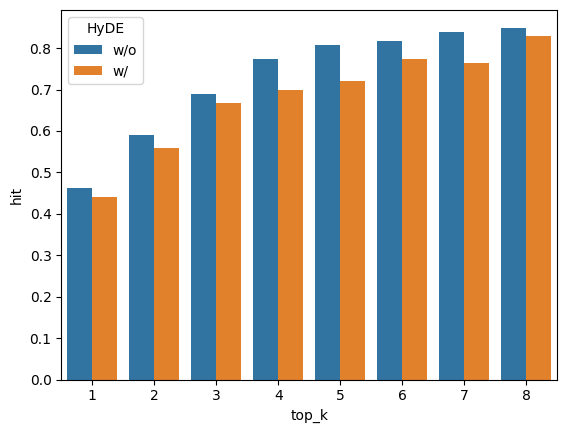

In [21]:
import seaborn as sns

sns.barplot(x='top_k', y='hit', hue='HyDE', data=hit_stat_df, errorbar=None)

# 问答全流程

In [18]:
from langchain.llms import Ollama

llm = Ollama(
    model='qwen2:7b-instruct',
    base_url='http://localhost:11434'
)

In [21]:
def rag(vector_db, query, n_chunks=4):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()

    chunks = vector_db.similarity_search(query, k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)

    return llm.invoke(prompt), chunks

In [22]:
print(rag(hyde_vector_db, '2023年10月美国ISM制造业PMI指数较上月有何变化？')[0])

2023年10月美国ISM制造业PMI指数较上个月大幅下降了2.3个百分点。


## 预测

In [23]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(prediction_df, vector_db, n_chunks):
    prediction_df = prediction_df.copy()

    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(vector_db, question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }
    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

In [24]:
pred_df = predict(prediction_df, hyde_vector_db, n_chunks=3)

  0%|          | 0/100 [00:00<?, ?it/s]

# 评估

In [25]:
from langchain_openai import ChatOpenAI

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

import time

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        result = judge_llm.invoke(prompt).content
        results.append(result)

        time.sleep(1)
    return results

In [26]:
pred_df['raw_score'] = evaluate(pred_df)

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
pred_df['raw_score'].unique()

array(['是', '否'], dtype=object)

In [28]:
pred_df['score'] = (pred_df['raw_score'] == '是').astype(int)

In [29]:
pred_df['score'].mean()

0.67